# Hyperparameters training for Gaussian Process kernels

This code compares the kernel's hyperparameters  trained using 3 codes:
* SKlearn
* GPy
* TFGP - **tfgp_trainer** was written for SLAC National Lab, and uses Tensorflow.   

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore")

# Load data

For this example we load exprimental data from SPEAR3 storage ring at SLAC National Lab.
https://www-ssrl.slac.stanford.edu/spear3/

* X: Input include 13 controls (quadropole current in [mA]).
* Y: Objective includes the beam loss rate [mA/min].


In [10]:
df = pd.read_excel('Data/spear_data.xlsx')
X=df.iloc[:,0:13] 
Y=df['objective']
print('Y.shape',Y.shape,'\nX.shape',X.shape)

Y.shape (120,) 
X.shape (120, 13)


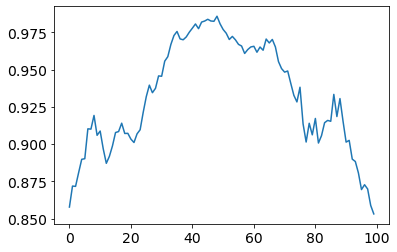

In [13]:
np.amax(x)
plt.plot(y[100:200])

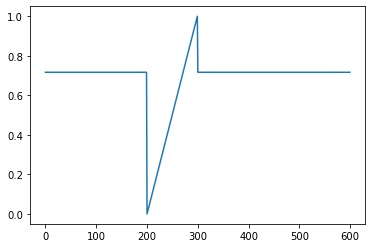

In [3]:
plt.plot(x[:,4])

In [2]:
# combine the data from linescans and the data from a test GP run

x = np.load('Results/Linescans/VGG16_30mrademit+defocus_30mrad_test12_attempt5/OBJ_x.npy')
# x = np.concatenate((x, np.load('Obj_x_GPrun.npy')),axis=0)
# x = x[0:200, 0:2]
print(x.shape)
X = pd.DataFrame(x)

y = np.load('Results/Linescans/VGG16_30mrademit+defocus_30mrad_test12_attempt5/OBJ_y.npy')
# y = y[0:200]
# y = np.concatenate((y, np.load('Obj_y_GPrun.npy')),axis=0)
print(y.shape)
Y = pd.DataFrame(y).squeeze()

print('Y.shape',Y.shape,'\nX.shape',X.shape)

(600, 6)
(600,)
Y.shape (600,) 
X.shape (600, 6)


In [12]:
x = np.load('S2_linescan.npy')
X = pd.DataFrame(x)

y = np.load('Defocus_linescan.npy')
Y = pd.DataFrame(y)
Y = pd.DataFrame(y).squeeze()

print('Y.shape',Y.shape,'\nX.shape',X.shape)

Y.shape (100,) 
X.shape (100, 1)


# Training using TFGP trainer

In [4]:
X

,0,1,2,3,4,5
0,0.000000,0.505875,0.5,0.494400,0.716538,0.790129
1,0.010101,0.505875,0.5,0.494400,0.716538,0.790129
2,0.020202,0.505875,0.5,0.494400,0.716538,0.790129
3,0.030303,0.505875,0.5,0.494400,0.716538,0.790129
4,0.040404,0.505875,0.5,0.494400,0.716538,0.790129
...,...,...,...,...,...,...
595,0.276787,0.505875,0.5,0.959596,0.716538,0.790129
596,0.276787,0.505875,0.5,0.969697,0.716538,0.790129
597,0.276787,0.505875,0.5,0.979798,0.716538,0.790129
598,0.276787,0.505875,0.5,0.989899,0.716538,0.790129


In [5]:
from Modules.tfgp_trainer import tfgp_trainer
tf.compat.v1.disable_eager_execution()

In [6]:
Niter = 2000

t0 = time.time()
tfgp = tfgp_trainer(X, Y,verbose=0)

tfgp.train(lr=0.005, 
           niter=Niter,
           optimizer=[tf.compat.v1.train.AdamOptimizer, tf.optimizers.SGD, tf.optimizers.RMSprop][0],
           gradient_clipping=0,
           kernel=['rbf','matern32','matern52'][0],
           correlations = False,
           offset = False,
           monitor_period=None,
           monitor_gradient=None) 

tfgp_t = time.time()-t0
print ('took ',tfgp_t ,' seconds')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


100% (2000 of 2000) |####################| Elapsed Time: 0:01:25 Time:  0:01:25


took  86.34655475616455  seconds


We can then plot results to see behaviour during the optimization and convergance.

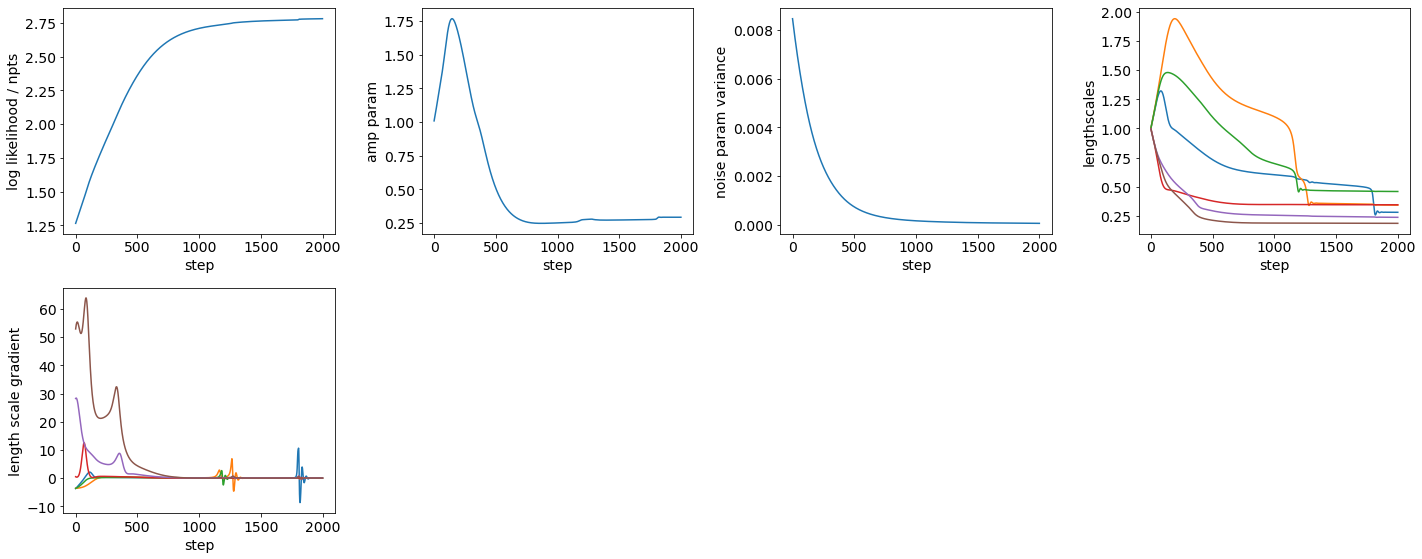

logLiklihod 1668.9519421153261 
 amp 0.2928136351136734 
 noise 5.398933927872703e-05 
 ls [0.2801918  0.34187636 0.45879202 0.34458577 0.23702228 0.1854476 ]


In [7]:
from Modules.utils import GP_plot_results
tfgp_results = GP_plot_results(tfgp,Y)

#  Training using SKlearn

In [8]:
from Modules.sk_trainer import sk_trainer
sk=sk_trainer()
sk.sk_train(X, Y, kernels=['rbf'], offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
took  15.434944868087769  seconds
Inital kernel: 3.16**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.01)
Learned kernel: 0.541**2 * RBF(length_scale=[0.277, 0.337, 0.456, 0.344, 0.234, 0.185]) + WhiteKernel(noise_level=0.000135)
Log-marginal-likelihood: 1671.255


#  Training using to GPy

In [9]:
from Modules.gpy_trainer import gpy_trainer
gpy=gpy_trainer()
gpy.gpy_train(X, Y[:,None], kernels= ['rbf'], max_iters=5000, offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
Optimization restart 1/5, f = -1671.2552987978077
Optimization restart 2/5, f = -1671.2552987837557
Optimization restart 3/5, f = -1671.2552987730871
Optimization restart 4/5, f = -1666.216002658554
Optimization restart 5/5, f = -1671.2552977822274
took  8.209022283554077  seconds
Log-marginal-likelihood: 1671.255


# Comparison of hyperparameters from all codes

In [10]:
# collect the results into a pandas dataframe to display
pd.DataFrame({"Param": ['time','negative log likelihood', 'amplitude', 'noise', 'offset'],
              "tfgp": [tfgp_t, tfgp_results['ll'], tfgp_results['amp_param'], tfgp_results['noise_param_variance'] , tfgp_results['offset_param']],
              "SK": [sk.sk_t, sk.results['ll'], sk.results['amp_param'], sk.results['noise_param_variance'] , sk.results['offset_param']],
              "GPy": [gpy.gpy_t, gpy.results['ll'], gpy.results['amp_param'], gpy.results['noise_param_variance'] , gpy.results['offset_param']],
             })


,Param,tfgp,SK,GPy
0,time,86.346555,15.434945,8.209022
1,negative log likelihood,-1668.951942,1671.255299,1671.255299
2,amplitude,0.292814,0.292918,0.292910
3,noise,0.000054,0.000135,0.000067
4,offset,NaN,NaN,NaN


In [11]:
print('Lengthscales Comparison')
pd.DataFrame({"": X.keys(),
#               "Param":['HP','HP diff','S6','S7','OBJ','S3','S4'],
              "tfgp": tfgp_results['length_scale_param'],
              "SK": sk.results['length_scale_param'] ,
              "GPy": gpy.results['length_scale_param']
             })

Lengthscales Comparison


,,tfgp,SK,GPy
0,0,0.280192,0.276946,0.276944
1,1,0.341876,0.336612,0.336611
2,2,0.458792,0.456032,0.456033
3,3,0.344586,0.344018,0.344017
4,4,0.237022,0.233698,0.233696
5,5,0.185448,0.185148,0.185146


In [ ]:
df.to_csv('out.csv', index=False)